## Setting up the Working Directory
This cell is to ensure we change the directory to anomalib source code to have access to the datasets and config files. We assume that you already went through `001_getting_started.ipynb` and install the required packages.

In [1]:
import os
from functools import partial, update_wrapper
from pathlib import Path
from types import MethodType
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "200_models":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/100_datamodules/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)
dataset_root = root_directory / "datasets" / "MVTec"

# Train a Model via API

This notebook demonstrates how to train, test and infer the FastFlow model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.

## Imports

In [2]:
from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader

from anomalib.data import InferenceDataset, TaskType
from anomalib.data.mvtec import MVTec
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.post_processing import (
    NormalizationMethod,
    ThresholdMethod,
    superimpose_anomaly_map,
)
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    PostProcessingConfigurationCallback,
)

/home/user/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:

In [3]:
task = TaskType.SEGMENTATION

In [4]:
datamodule = MVTec(
    root=dataset_root,
    category="bottle",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=8,
    task=task,
)
datamodule.setup()
i, data = next(enumerate(datamodule.test_dataloader()))
print(f'Image Shape: {data["image"].shape} Mask Shape: {data["mask"].shape}')

Image Shape: torch.Size([32, 3, 256, 256]) Mask Shape: torch.Size([32, 256, 256])


## FastFlow Model

Now that we have created the MVTec datamodule, we could create the FastFlow model. We could start with printing its docstring.

In [5]:
Fastflow??

In [6]:
model = Fastflow(input_size=(256, 256), backbone="resnet18", flow_steps=8)

/home/user/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
/home/user/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Depending on the `training` mode, `model` returns two different outputs. If the model is in `training` mode, it returns the hidden variable and the log of the jacobian, based on the feature maps.

In [7]:
model.training = True
train_output = model(data["image"])
hidden_variables, log_jacobian = train_output
print(f"Hidden Variable Shape: {hidden_variables[0].shape}")

Hidden Variable Shape: torch.Size([32, 64, 64, 64])


During the test/inference mode, the model returns an anomaly heatmap localizing the anomalous regions.

In [8]:
model.model.training = False
anomaly_map = model(data["image"])
print(f"Anomaly Map Shape: {anomaly_map.shape}")

Anomaly Map Shape: torch.Size([32, 1, 256, 256])


## Optimizer

`LightningModule` has `configure_optimizer` method that returns the optimizer object. This is not implemented in the FastFlow model. Instead, it is left to the user to make it configurable by either CLI or API. Here we will be configuring it via the API. To do so, we first need to create the optimizer object, wrap it around a function and finally inject this function into the model class.

In [9]:
def configure_optimizers(lightning_module: LightningModule, optimizer: Optimizer) -> Any:  # pylint: disable=W0613,W0621
    """Override to customize the LightningModule.configure_optimizers` method."""
    return optimizer


optimizer = Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
fn = partial(configure_optimizers, optimizer=optimizer)
update_wrapper(fn, configure_optimizers)  # necessary for `is_overridden`
model.configure_optimizers = MethodType(fn, model)

## Callbacks

To train the model properly, we will to add some other "non-essential" logic such as saving the weights, early-stopping, normalizing the anomaly scores and visualizing the input/output images. To achieve these we use `Callbacks`. Anomalib has its own callbacks and also supports PyTorch Lightning's native callbacks. So, let's create the list of callbacks we want to execute during the training.

In [10]:
callbacks = [
    MetricsConfigurationCallback(
        task=task,
        image_metrics=["AUROC"],
        pixel_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        mode="max",
        monitor="pixel_AUROC",
    ),
    EarlyStopping(
        monitor="pixel_AUROC",
        mode="max",
        patience=3,
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    ImageVisualizerCallback(mode="full", task=task, image_save_path="./results/images"),
    MetricVisualizerCallback(mode="full", task=task, image_save_path="./results/images"),
]

## Training

Now that we set up the datamodule, model, optimizer and the callbacks, we could now train the model.

The final component to train the model is `pytorch_lightning` `Trainer` object, which handles train/test/predict pipeline. Let's create the trainer object to train the model.

In [11]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    max_epochs=100,
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) to see how it could be tweaked to your needs.

Let's train the model now.

In [12]:
trainer.fit(datamodule=datamodule, model=model)

Missing logger folder: /home/user/actions-runner/_work/anomalib/anomalib/lightning_logs


/home/user/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]



  | Name            | Type                     | Params
-------------------------------------------------------------
0 | image_threshold | AnomalyScoreThreshold    | 0     
1 | pixel_threshold | AnomalyScoreThreshold    | 0     
2 | model           | FastflowModel            | 7.7 M 
3 | loss            | FastflowLoss             | 0     
4 | image_metrics   | AnomalibMetricCollection | 0     
5 | pixel_metrics   | AnomalibMetricCollection | 0     
-------------------------------------------------------------
3.5 M     Trainable params
4.2 M     Non-trainable params
7.7 M     Total params
30.678    Total estimated model params size (MB)


/home/user/conda/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


Sanity Checking: 0it [00:00, ?it/s]

Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s]

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

/home/user/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: `torchmetrics.functional.auc` has been move to `torchmetrics.utilities.compute` in v0.10 and will be removed in v0.11.
  warnings.warn(*args, **kwargs)
/home/user/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s] 

Epoch 0:  10%|█         | 1/10 [00:01<00:17,  1.97s/it]

Epoch 0:  10%|█         | 1/10 [00:01<00:17,  1.98s/it, loss=2.33e+05, v_num=0, train_loss_step=2.33e+5]

/home/user/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0:  20%|██        | 2/10 [00:02<00:08,  1.05s/it, loss=2.33e+05, v_num=0, train_loss_step=2.33e+5]

Epoch 0:  20%|██        | 2/10 [00:02<00:08,  1.05s/it, loss=2.2e+05, v_num=0, train_loss_step=2.06e+5] 

Epoch 0:  30%|███       | 3/10 [00:02<00:05,  1.35it/s, loss=2.2e+05, v_num=0, train_loss_step=2.06e+5]

Epoch 0:  30%|███       | 3/10 [00:02<00:05,  1.35it/s, loss=2.08e+05, v_num=0, train_loss_step=1.83e+5]

Epoch 0:  40%|████      | 4/10 [00:02<00:03,  1.71it/s, loss=2.08e+05, v_num=0, train_loss_step=1.83e+5]

Epoch 0:  40%|████      | 4/10 [00:02<00:03,  1.71it/s, loss=1.97e+05, v_num=0, train_loss_step=1.64e+5]

Epoch 0:  50%|█████     | 5/10 [00:02<00:02,  2.04it/s, loss=1.97e+05, v_num=0, train_loss_step=1.64e+5]

Epoch 0:  50%|█████     | 5/10 [00:02<00:02,  2.04it/s, loss=1.86e+05, v_num=0, train_loss_step=1.45e+5]

Epoch 0:  60%|██████    | 6/10 [00:02<00:01,  2.33it/s, loss=1.86e+05, v_num=0, train_loss_step=1.45e+5]

Epoch 0:  60%|██████    | 6/10 [00:02<00:01,  2.33it/s, loss=1.77e+05, v_num=0, train_loss_step=1.28e+5]

Epoch 0:  70%|███████   | 7/10 [00:02<00:01,  2.64it/s, loss=1.77e+05, v_num=0, train_loss_step=1.28e+5]

Epoch 0:  70%|███████   | 7/10 [00:02<00:01,  2.63it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5]

/home/user/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 17. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 11.75it/s]

Epoch 0:  80%|████████  | 8/10 [00:04<00:01,  1.67it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.73it/s]

Epoch 0:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 12.07it/s]

Epoch 0: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5]

Epoch 0: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5, pixel_AUROC=0.810]

Epoch 0: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]         

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  10%|█         | 1/10 [00:02<00:20,  2.23s/it, loss=1.67e+05, v_num=0, train_loss_step=1.13e+5, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  10%|█         | 1/10 [00:02<00:20,  2.24s/it, loss=1.59e+05, v_num=0, train_loss_step=9.69e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  20%|██        | 2/10 [00:02<00:09,  1.19s/it, loss=1.59e+05, v_num=0, train_loss_step=9.69e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  20%|██        | 2/10 [00:02<00:09,  1.19s/it, loss=1.5e+05, v_num=0, train_loss_step=8.02e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5] 

Epoch 1:  30%|███       | 3/10 [00:02<00:05,  1.21it/s, loss=1.5e+05, v_num=0, train_loss_step=8.02e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=1.41e+05, v_num=0, train_loss_step=6.42e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=1.41e+05, v_num=0, train_loss_step=6.42e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=1.33e+05, v_num=0, train_loss_step=4.97e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s, loss=1.33e+05, v_num=0, train_loss_step=4.97e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s, loss=1.25e+05, v_num=0, train_loss_step=3.47e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  60%|██████    | 6/10 [00:02<00:01,  2.11it/s, loss=1.25e+05, v_num=0, train_loss_step=3.47e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  60%|██████    | 6/10 [00:02<00:01,  2.11it/s, loss=1.17e+05, v_num=0, train_loss_step=2.03e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  70%|███████   | 7/10 [00:02<00:01,  2.38it/s, loss=1.17e+05, v_num=0, train_loss_step=2.03e+4, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1:  70%|███████   | 7/10 [00:02<00:01,  2.38it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.78it/s]

Epoch 1:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.48it/s]

Epoch 1:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.47it/s]

Epoch 1: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.810, train_loss_epoch=1.71e+5]

Epoch 1: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.904, train_loss_epoch=1.71e+5]

Epoch 1: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]         

Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  10%|█         | 1/10 [00:02<00:20,  2.26s/it, loss=1.09e+05, v_num=0, train_loss_step=7.52e+3, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  10%|█         | 1/10 [00:02<00:20,  2.26s/it, loss=1.01e+05, v_num=0, train_loss_step=-7.12e+3, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  20%|██        | 2/10 [00:02<00:09,  1.19s/it, loss=1.01e+05, v_num=0, train_loss_step=-7.12e+3, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  20%|██        | 2/10 [00:02<00:09,  1.19s/it, loss=9.36e+04, v_num=0, train_loss_step=-2.12e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=9.36e+04, v_num=0, train_loss_step=-2.12e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=8.61e+04, v_num=0, train_loss_step=-3.3e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4] 

Epoch 2:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=8.61e+04, v_num=0, train_loss_step=-3.3e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=7.87e+04, v_num=0, train_loss_step=-4.8e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s, loss=7.87e+04, v_num=0, train_loss_step=-4.8e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s, loss=7.13e+04, v_num=0, train_loss_step=-6.17e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  60%|██████    | 6/10 [00:02<00:01,  2.11it/s, loss=7.13e+04, v_num=0, train_loss_step=-6.17e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  60%|██████    | 6/10 [00:02<00:01,  2.11it/s, loss=6.41e+04, v_num=0, train_loss_step=-7.33e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  70%|███████   | 7/10 [00:02<00:01,  2.38it/s, loss=6.41e+04, v_num=0, train_loss_step=-7.33e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2:  70%|███████   | 7/10 [00:02<00:01,  2.38it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 11.40it/s]

Epoch 2:  80%|████████  | 8/10 [00:05<00:01,  1.57it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.84it/s]

Epoch 2:  90%|█████████ | 9/10 [00:05<00:00,  1.73it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.99it/s]

Epoch 2: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.904, train_loss_epoch=5.36e+4]

Epoch 2: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.948, train_loss_epoch=5.36e+4]

Epoch 2: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]         

Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  10%|█         | 1/10 [00:02<00:19,  2.20s/it, loss=4.83e+04, v_num=0, train_loss_step=-8.22e+4, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  10%|█         | 1/10 [00:02<00:19,  2.21s/it, loss=3.31e+04, v_num=0, train_loss_step=-9.75e+4, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  20%|██        | 2/10 [00:02<00:09,  1.17s/it, loss=3.31e+04, v_num=0, train_loss_step=-9.75e+4, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  20%|██        | 2/10 [00:02<00:09,  1.17s/it, loss=1.87e+04, v_num=0, train_loss_step=-1.05e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  30%|███       | 3/10 [00:02<00:05,  1.22it/s, loss=1.87e+04, v_num=0, train_loss_step=-1.05e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  30%|███       | 3/10 [00:02<00:05,  1.22it/s, loss=4.86e+03, v_num=0, train_loss_step=-1.13e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, loss=4.86e+03, v_num=0, train_loss_step=-1.13e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, loss=-8.62e+03, v_num=0, train_loss_step=-1.24e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s, loss=-8.62e+03, v_num=0, train_loss_step=-1.24e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s, loss=-2.19e+04, v_num=0, train_loss_step=-1.37e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  60%|██████    | 6/10 [00:02<00:01,  2.12it/s, loss=-2.19e+04, v_num=0, train_loss_step=-1.37e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  60%|██████    | 6/10 [00:02<00:01,  2.12it/s, loss=-3.48e+04, v_num=0, train_loss_step=-1.45e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  70%|███████   | 7/10 [00:02<00:01,  2.39it/s, loss=-3.48e+04, v_num=0, train_loss_step=-1.45e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3:  70%|███████   | 7/10 [00:02<00:01,  2.39it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 11.54it/s]

Epoch 3:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.82it/s]

Epoch 3:  90%|█████████ | 9/10 [00:05<00:00,  1.74it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 12.03it/s]

Epoch 3: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.948, train_loss_epoch=-4.41e+4]

Epoch 3: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.962, train_loss_epoch=-4.41e+4]

Epoch 3: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]         

Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  10%|█         | 1/10 [00:02<00:19,  2.19s/it, loss=-4.74e+04, v_num=0, train_loss_step=-1.56e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  10%|█         | 1/10 [00:02<00:19,  2.19s/it, loss=-5.96e+04, v_num=0, train_loss_step=-1.63e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  20%|██        | 2/10 [00:02<00:09,  1.16s/it, loss=-5.96e+04, v_num=0, train_loss_step=-1.63e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  20%|██        | 2/10 [00:02<00:09,  1.16s/it, loss=-7.16e+04, v_num=0, train_loss_step=-1.75e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, loss=-7.16e+04, v_num=0, train_loss_step=-1.75e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, loss=-8.32e+04, v_num=0, train_loss_step=-1.83e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  40%|████      | 4/10 [00:02<00:03,  1.57it/s, loss=-8.32e+04, v_num=0, train_loss_step=-1.83e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  40%|████      | 4/10 [00:02<00:03,  1.57it/s, loss=-9.46e+04, v_num=0, train_loss_step=-1.94e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  50%|█████     | 5/10 [00:02<00:02,  1.87it/s, loss=-9.46e+04, v_num=0, train_loss_step=-1.94e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  50%|█████     | 5/10 [00:02<00:02,  1.87it/s, loss=-1.06e+05, v_num=0, train_loss_step=-2e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]   

Epoch 4:  60%|██████    | 6/10 [00:02<00:01,  2.15it/s, loss=-1.06e+05, v_num=0, train_loss_step=-2e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  60%|██████    | 6/10 [00:02<00:01,  2.15it/s, loss=-1.16e+05, v_num=0, train_loss_step=-2.07e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  70%|███████   | 7/10 [00:02<00:01,  2.42it/s, loss=-1.16e+05, v_num=0, train_loss_step=-2.07e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4:  70%|███████   | 7/10 [00:02<00:01,  2.42it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.86it/s]

Epoch 4:  80%|████████  | 8/10 [00:04<00:01,  1.60it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.03it/s]

Epoch 4:  90%|█████████ | 9/10 [00:05<00:00,  1.76it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.36it/s]

Epoch 4: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.962, train_loss_epoch=-1.23e+5]

Epoch 4: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.964, train_loss_epoch=-1.23e+5]

Epoch 4: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]         

Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  10%|█         | 1/10 [00:02<00:20,  2.25s/it, loss=-1.27e+05, v_num=0, train_loss_step=-2.14e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  10%|█         | 1/10 [00:02<00:20,  2.26s/it, loss=-1.37e+05, v_num=0, train_loss_step=-2.21e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  20%|██        | 2/10 [00:02<00:09,  1.19s/it, loss=-1.37e+05, v_num=0, train_loss_step=-2.21e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  20%|██        | 2/10 [00:02<00:09,  1.19s/it, loss=-1.46e+05, v_num=0, train_loss_step=-2.29e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=-1.46e+05, v_num=0, train_loss_step=-2.29e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=-1.56e+05, v_num=0, train_loss_step=-2.32e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=-1.56e+05, v_num=0, train_loss_step=-2.32e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=-1.65e+05, v_num=0, train_loss_step=-2.44e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s, loss=-1.65e+05, v_num=0, train_loss_step=-2.44e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s, loss=-1.74e+05, v_num=0, train_loss_step=-2.48e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  60%|██████    | 6/10 [00:02<00:01,  2.10it/s, loss=-1.74e+05, v_num=0, train_loss_step=-2.48e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  60%|██████    | 6/10 [00:02<00:01,  2.10it/s, loss=-1.82e+05, v_num=0, train_loss_step=-2.56e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  70%|███████   | 7/10 [00:02<00:01,  2.37it/s, loss=-1.82e+05, v_num=0, train_loss_step=-2.56e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5:  70%|███████   | 7/10 [00:02<00:01,  2.36it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]  

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 11.36it/s]

Epoch 5:  80%|████████  | 8/10 [00:05<00:01,  1.59it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.83it/s]

Epoch 5:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 12.05it/s]

Epoch 5: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.964, train_loss_epoch=-1.89e+5]

Epoch 5: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.970, train_loss_epoch=-1.89e+5]

Epoch 5: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5] 

Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]         

Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  10%|█         | 1/10 [00:02<00:20,  2.26s/it, loss=-1.9e+05, v_num=0, train_loss_step=-2.6e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  10%|█         | 1/10 [00:02<00:20,  2.27s/it, loss=-1.99e+05, v_num=0, train_loss_step=-2.7e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  20%|██        | 2/10 [00:02<00:09,  1.20s/it, loss=-1.99e+05, v_num=0, train_loss_step=-2.7e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  20%|██        | 2/10 [00:02<00:09,  1.20s/it, loss=-2.07e+05, v_num=0, train_loss_step=-2.74e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  30%|███       | 3/10 [00:02<00:05,  1.19it/s, loss=-2.07e+05, v_num=0, train_loss_step=-2.74e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  30%|███       | 3/10 [00:02<00:05,  1.19it/s, loss=-2.14e+05, v_num=0, train_loss_step=-2.82e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  40%|████      | 4/10 [00:02<00:03,  1.52it/s, loss=-2.14e+05, v_num=0, train_loss_step=-2.82e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  40%|████      | 4/10 [00:02<00:03,  1.52it/s, loss=-2.22e+05, v_num=0, train_loss_step=-2.85e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s, loss=-2.22e+05, v_num=0, train_loss_step=-2.85e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s, loss=-2.29e+05, v_num=0, train_loss_step=-2.91e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  60%|██████    | 6/10 [00:02<00:01,  2.10it/s, loss=-2.29e+05, v_num=0, train_loss_step=-2.91e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  60%|██████    | 6/10 [00:02<00:01,  2.10it/s, loss=-2.36e+05, v_num=0, train_loss_step=-2.87e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  70%|███████   | 7/10 [00:02<00:01,  2.37it/s, loss=-2.36e+05, v_num=0, train_loss_step=-2.87e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6:  70%|███████   | 7/10 [00:02<00:01,  2.37it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.07it/s]

Epoch 6:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  9.69it/s]

Epoch 6:  90%|█████████ | 9/10 [00:05<00:00,  1.74it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.08it/s]

Epoch 6: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.4e+5]

Epoch 6: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]         

Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  10%|█         | 1/10 [00:02<00:20,  2.30s/it, loss=-2.42e+05, v_num=0, train_loss_step=-2.95e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  10%|█         | 1/10 [00:02<00:20,  2.30s/it, loss=-2.48e+05, v_num=0, train_loss_step=-2.98e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  20%|██        | 2/10 [00:02<00:09,  1.22s/it, loss=-2.48e+05, v_num=0, train_loss_step=-2.98e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  20%|██        | 2/10 [00:02<00:09,  1.22s/it, loss=-2.55e+05, v_num=0, train_loss_step=-3.08e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  30%|███       | 3/10 [00:02<00:05,  1.18it/s, loss=-2.55e+05, v_num=0, train_loss_step=-3.08e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  30%|███       | 3/10 [00:02<00:05,  1.18it/s, loss=-2.61e+05, v_num=0, train_loss_step=-3.11e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  40%|████      | 4/10 [00:02<00:03,  1.50it/s, loss=-2.61e+05, v_num=0, train_loss_step=-3.11e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  40%|████      | 4/10 [00:02<00:03,  1.50it/s, loss=-2.67e+05, v_num=0, train_loss_step=-3.18e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  50%|█████     | 5/10 [00:02<00:02,  1.80it/s, loss=-2.67e+05, v_num=0, train_loss_step=-3.18e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  50%|█████     | 5/10 [00:02<00:02,  1.80it/s, loss=-2.72e+05, v_num=0, train_loss_step=-3.23e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  60%|██████    | 6/10 [00:02<00:01,  2.07it/s, loss=-2.72e+05, v_num=0, train_loss_step=-3.23e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  60%|██████    | 6/10 [00:02<00:01,  2.07it/s, loss=-2.78e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5] 

Epoch 7:  70%|███████   | 7/10 [00:02<00:01,  2.34it/s, loss=-2.78e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7:  70%|███████   | 7/10 [00:02<00:01,  2.34it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.22it/s]

Epoch 7:  80%|████████  | 8/10 [00:05<00:01,  1.56it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  9.86it/s]

Epoch 7:  90%|█████████ | 9/10 [00:05<00:00,  1.72it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.17it/s]

Epoch 7: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-2.83e+5]

Epoch 7: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]         

Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  10%|█         | 1/10 [00:02<00:20,  2.28s/it, loss=-2.84e+05, v_num=0, train_loss_step=-3.3e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  10%|█         | 1/10 [00:02<00:20,  2.28s/it, loss=-2.89e+05, v_num=0, train_loss_step=-3.42e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  20%|██        | 2/10 [00:02<00:09,  1.20s/it, loss=-2.89e+05, v_num=0, train_loss_step=-3.42e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  20%|██        | 2/10 [00:02<00:09,  1.20s/it, loss=-2.95e+05, v_num=0, train_loss_step=-3.47e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=-2.95e+05, v_num=0, train_loss_step=-3.47e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  30%|███       | 3/10 [00:02<00:05,  1.20it/s, loss=-3e+05, v_num=0, train_loss_step=-3.52e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]   

Epoch 8:  40%|████      | 4/10 [00:02<00:03,  1.54it/s, loss=-3e+05, v_num=0, train_loss_step=-3.52e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  40%|████      | 4/10 [00:02<00:03,  1.53it/s, loss=-3.06e+05, v_num=0, train_loss_step=-3.59e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s, loss=-3.06e+05, v_num=0, train_loss_step=-3.59e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s, loss=-3.11e+05, v_num=0, train_loss_step=-3.62e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  60%|██████    | 6/10 [00:02<00:01,  2.12it/s, loss=-3.11e+05, v_num=0, train_loss_step=-3.62e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  60%|██████    | 6/10 [00:02<00:01,  2.12it/s, loss=-3.17e+05, v_num=0, train_loss_step=-3.7e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5] 

Epoch 8:  70%|███████   | 7/10 [00:02<00:01,  2.41it/s, loss=-3.17e+05, v_num=0, train_loss_step=-3.7e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8:  70%|███████   | 7/10 [00:02<00:01,  2.41it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.56it/s]

Epoch 8:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.13it/s]

Epoch 8:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.10it/s]

Epoch 8: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.970, train_loss_epoch=-3.16e+5]

Epoch 8: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.971, train_loss_epoch=-3.16e+5]

Epoch 8: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]         

Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  10%|█         | 1/10 [00:02<00:20,  2.23s/it, loss=-3.22e+05, v_num=0, train_loss_step=-3.76e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  10%|█         | 1/10 [00:02<00:20,  2.24s/it, loss=-3.27e+05, v_num=0, train_loss_step=-3.72e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  20%|██        | 2/10 [00:02<00:09,  1.18s/it, loss=-3.27e+05, v_num=0, train_loss_step=-3.72e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  20%|██        | 2/10 [00:02<00:09,  1.18s/it, loss=-3.32e+05, v_num=0, train_loss_step=-3.75e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  30%|███       | 3/10 [00:02<00:05,  1.22it/s, loss=-3.32e+05, v_num=0, train_loss_step=-3.75e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  30%|███       | 3/10 [00:02<00:05,  1.22it/s, loss=-3.37e+05, v_num=0, train_loss_step=-3.82e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, loss=-3.37e+05, v_num=0, train_loss_step=-3.82e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, loss=-3.41e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s, loss=-3.41e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s, loss=-3.46e+05, v_num=0, train_loss_step=-3.82e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  60%|██████    | 6/10 [00:02<00:01,  2.12it/s, loss=-3.46e+05, v_num=0, train_loss_step=-3.82e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  60%|██████    | 6/10 [00:02<00:01,  2.12it/s, loss=-3.51e+05, v_num=0, train_loss_step=-3.92e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  70%|███████   | 7/10 [00:02<00:01,  2.39it/s, loss=-3.51e+05, v_num=0, train_loss_step=-3.92e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9:  70%|███████   | 7/10 [00:02<00:01,  2.39it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.60it/s]

Epoch 9:  80%|████████  | 8/10 [00:05<00:01,  1.59it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.56it/s]

Epoch 9:  90%|█████████ | 9/10 [00:05<00:00,  1.76it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.93it/s]

Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.971, train_loss_epoch=-3.57e+5]

Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.972, train_loss_epoch=-3.57e+5]

Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]         

Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  10%|█         | 1/10 [00:02<00:20,  2.22s/it, loss=-3.56e+05, v_num=0, train_loss_step=-3.91e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  10%|█         | 1/10 [00:02<00:20,  2.23s/it, loss=-3.6e+05, v_num=0, train_loss_step=-3.95e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5] 

Epoch 10:  20%|██        | 2/10 [00:02<00:09,  1.17s/it, loss=-3.6e+05, v_num=0, train_loss_step=-3.95e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  20%|██        | 2/10 [00:02<00:09,  1.17s/it, loss=-3.65e+05, v_num=0, train_loss_step=-4.02e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  30%|███       | 3/10 [00:02<00:05,  1.22it/s, loss=-3.65e+05, v_num=0, train_loss_step=-4.02e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  30%|███       | 3/10 [00:02<00:05,  1.22it/s, loss=-3.69e+05, v_num=0, train_loss_step=-4.08e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, loss=-3.69e+05, v_num=0, train_loss_step=-4.08e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  40%|████      | 4/10 [00:02<00:03,  1.55it/s, loss=-3.74e+05, v_num=0, train_loss_step=-4.14e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s, loss=-3.74e+05, v_num=0, train_loss_step=-4.14e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s, loss=-3.78e+05, v_num=0, train_loss_step=-4.21e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  60%|██████    | 6/10 [00:02<00:01,  2.13it/s, loss=-3.78e+05, v_num=0, train_loss_step=-4.21e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  60%|██████    | 6/10 [00:02<00:01,  2.13it/s, loss=-3.83e+05, v_num=0, train_loss_step=-4.19e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  70%|███████   | 7/10 [00:02<00:01,  2.40it/s, loss=-3.83e+05, v_num=0, train_loss_step=-4.19e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10:  70%|███████   | 7/10 [00:02<00:01,  2.40it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.55it/s]

Epoch 10:  80%|████████  | 8/10 [00:05<00:01,  1.57it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.49it/s]

Epoch 10:  90%|█████████ | 9/10 [00:05<00:00,  1.74it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.61it/s]

Epoch 10: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.972, train_loss_epoch=-3.83e+5]

Epoch 10: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.971, train_loss_epoch=-3.83e+5]

Epoch 10: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]         

Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  10%|█         | 1/10 [00:02<00:19,  2.19s/it, loss=-3.87e+05, v_num=0, train_loss_step=-4.24e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  10%|█         | 1/10 [00:02<00:19,  2.20s/it, loss=-3.91e+05, v_num=0, train_loss_step=-4.33e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  20%|██        | 2/10 [00:02<00:09,  1.16s/it, loss=-3.91e+05, v_num=0, train_loss_step=-4.33e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  20%|██        | 2/10 [00:02<00:09,  1.16s/it, loss=-3.95e+05, v_num=0, train_loss_step=-4.35e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, loss=-3.95e+05, v_num=0, train_loss_step=-4.35e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, loss=-3.99e+05, v_num=0, train_loss_step=-4.36e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  40%|████      | 4/10 [00:02<00:03,  1.56it/s, loss=-3.99e+05, v_num=0, train_loss_step=-4.36e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  40%|████      | 4/10 [00:02<00:03,  1.56it/s, loss=-4.03e+05, v_num=0, train_loss_step=-4.4e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5] 

Epoch 11:  50%|█████     | 5/10 [00:02<00:02,  1.86it/s, loss=-4.03e+05, v_num=0, train_loss_step=-4.4e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  50%|█████     | 5/10 [00:02<00:02,  1.86it/s, loss=-4.07e+05, v_num=0, train_loss_step=-4.49e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  60%|██████    | 6/10 [00:02<00:01,  2.14it/s, loss=-4.07e+05, v_num=0, train_loss_step=-4.49e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  60%|██████    | 6/10 [00:02<00:01,  2.14it/s, loss=-4.11e+05, v_num=0, train_loss_step=-4.52e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  70%|███████   | 7/10 [00:02<00:01,  2.42it/s, loss=-4.11e+05, v_num=0, train_loss_step=-4.52e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11:  70%|███████   | 7/10 [00:02<00:01,  2.42it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 11.19it/s]

Epoch 11:  80%|████████  | 8/10 [00:05<00:01,  1.59it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.94it/s]

Epoch 11:  90%|█████████ | 9/10 [00:05<00:00,  1.76it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 12.22it/s]

Epoch 11: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.11e+5]

Epoch 11: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]         

Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  10%|█         | 1/10 [00:02<00:19,  2.18s/it, loss=-4.15e+05, v_num=0, train_loss_step=-4.61e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  10%|█         | 1/10 [00:02<00:19,  2.19s/it, loss=-4.19e+05, v_num=0, train_loss_step=-4.62e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  20%|██        | 2/10 [00:02<00:09,  1.16s/it, loss=-4.19e+05, v_num=0, train_loss_step=-4.62e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  20%|██        | 2/10 [00:02<00:09,  1.16s/it, loss=-4.23e+05, v_num=0, train_loss_step=-4.63e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, loss=-4.23e+05, v_num=0, train_loss_step=-4.63e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  30%|███       | 3/10 [00:02<00:05,  1.23it/s, loss=-4.27e+05, v_num=0, train_loss_step=-4.68e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  40%|████      | 4/10 [00:02<00:03,  1.57it/s, loss=-4.27e+05, v_num=0, train_loss_step=-4.68e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  40%|████      | 4/10 [00:02<00:03,  1.56it/s, loss=-4.32e+05, v_num=0, train_loss_step=-4.75e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  50%|█████     | 5/10 [00:02<00:02,  1.87it/s, loss=-4.32e+05, v_num=0, train_loss_step=-4.75e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  50%|█████     | 5/10 [00:02<00:02,  1.87it/s, loss=-4.36e+05, v_num=0, train_loss_step=-4.76e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  60%|██████    | 6/10 [00:02<00:01,  2.15it/s, loss=-4.36e+05, v_num=0, train_loss_step=-4.76e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  60%|██████    | 6/10 [00:02<00:01,  2.15it/s, loss=-4.41e+05, v_num=0, train_loss_step=-4.83e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  70%|███████   | 7/10 [00:02<00:01,  2.42it/s, loss=-4.41e+05, v_num=0, train_loss_step=-4.83e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12:  70%|███████   | 7/10 [00:02<00:01,  2.42it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.99it/s]

Epoch 12:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 10.65it/s]

Epoch 12:  90%|█████████ | 9/10 [00:05<00:00,  1.65it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 11.99it/s]

Epoch 12: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.42e+5]

Epoch 12: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.72e+5]

Epoch 12: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s, loss=-4.45e+05, v_num=0, train_loss_step=-4.78e+5, pixel_AUROC=0.971, train_loss_epoch=-4.72e+5]

The training has finished after 12 epochs. This is because, we set the `EarlyStopping` criteria with a patience of 3, which terminated the training after `pixel_AUROC` stopped improving. If we increased the `patience`, the training would continue further.

## Testing

Now that we trained the model, we could test the model to check the overall performance on the test set. We will also be writing the output of the test images to a file since we set `VisualizerCallback` in `callbacks`.

In [13]:
trainer.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

Testing DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

Testing DataLoader 0:  33%|███▎      | 1/3 [00:08<00:16,  8.12s/it]

Testing DataLoader 0:  67%|██████▋   | 2/3 [00:15<00:07,  7.79s/it]

Testing DataLoader 0: 100%|██████████| 3/3 [00:20<00:00,  6.71s/it]

Testing DataLoader 0: 100%|██████████| 3/3 [00:20<00:00,  6.79s/it]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9992063045501709
       pixel_AUROC           0.97097247838974
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_AUROC': 0.97097247838974, 'image_AUROC': 0.9992063045501709}]

`trainer.test` returns the `pixel_AUROC` and `image_AUROC` results. We could also find the saved output in `images` directory.

In [14]:
!ls images

ls: cannot access 'images': No such file or directory


## Inference

Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an `InferenceDataset` to let you create an inference dataset. So let's try it.

In [15]:
inference_dataset = InferenceDataset(path=dataset_root / "bottle/test/broken_large/000.png", image_size=(256, 256))
inference_dataloader = DataLoader(dataset=inference_dataset)

We could utilize `Trainer`'s `predict` method to infer, and get the outputs to visualize

In [16]:
predictions = trainer.predict(model=model, dataloaders=inference_dataloader)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


/home/user/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 7it [00:00, ?it/s]

Predicting:   0%|          | 0/1 [00:00<00:00, -146070.29it/s]

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

`predictions` contain image, anomaly maps, predicted scores, labels and masks. These are all stored in a dictionary. We could check this by printing the `prediction` keys.

In [17]:
print(predictions.keys())

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])


In [18]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


## Visualization

To properly visualize the predictions, we will need to perform some post-processing operations.

Let's post-process each output one by one. We could start with the image. Each `image` is a tensor and within (0, 1) range. To visualize it, we need to denormalize it to (0, 255) scale. Anomalib already has a class for this. Let's use it.

In [19]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 29 
 Max Pixel: 255


/home/user/actions-runner/_work/anomalib/anomalib/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


We could now see that `image` is of a numpy array and within the range of \[0, 255\]. It's ready to be visualized now.

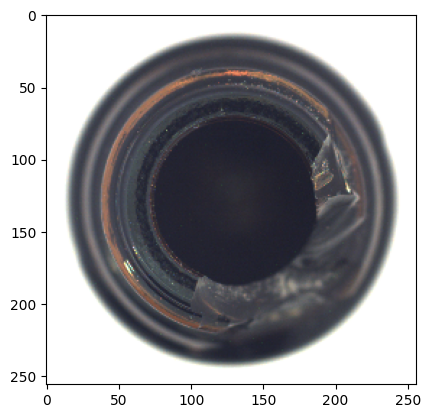

In [20]:
plt.imshow(image)

The second output of the predictions is the anomaly map. As can be seen above, it's also a torch tensor and of size `torch.Size([1, 1, 256, 256])`. We therefore need to convert it to numpy and squeeze the dimensions to make it `256x256` output to visualize.

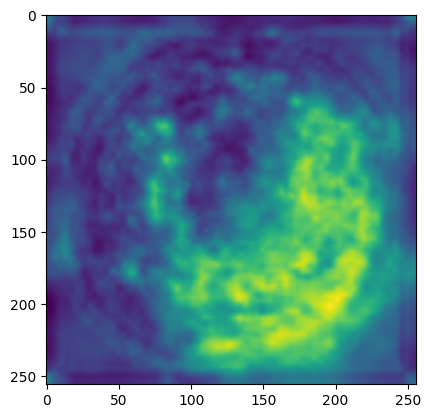

In [21]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

We could superimpose (overlay) the anomaly map on top of the original image to get a heat map. Anomalib has a built-in function to achieve this. Let's try it.

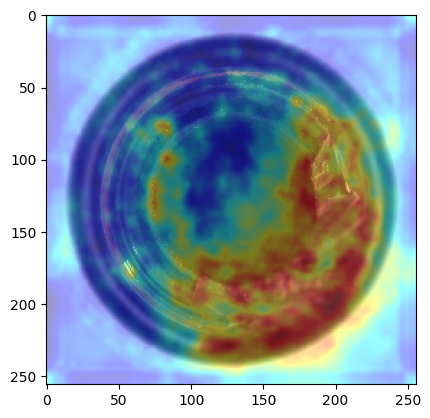

In [22]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

`predictions` also contains prediction scores and labels.

In [23]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(-0.0537) tensor(True)


The last part of the predictions is the mask that is predicted by the model. This is a boolean mask containing True/False for the abnormal/normal pixels, respectively.

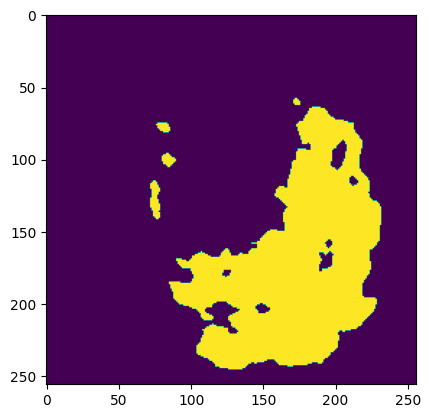

In [24]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

That wraps it! In this notebook, we show how we could train, test and finally infer a FastFlow model using Anomalib API.